# HANK-SAM

**Table of contents**<a id='toc0_'></a>    
- 1. [Steady state](#toc1_)    
  - 1.1. [Policy functions](#toc1_1_)    
  - 1.2. [Distribution](#toc1_2_)    
  - 1.3. [Spending in unemployment](#toc1_3_)    
- 2. [Effect of government spending](#toc2_)    
  - 2.1. [Tests](#toc2_1_)    
  - 2.2. [Jacobians](#toc2_2_)    
  - 2.3. [Response](#toc2_3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

This notebook shows how to **solve a Heterogenous Agent New Keynessian (HANK) model with a search-and-match (SAM) labor market** using the ``GEModelTools`` package.

In [1]:
%load_ext autoreload
%autoreload 2

import pickle
import numpy as np
import scipy.optimize as optimize

import matplotlib.pyplot as plt
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.alpha":"0.25", "grid.linestyle": "--"})
plt.rcParams.update({'font.size': 14})

from HANKSAMModel import HANKSAMModelClass

In [2]:
def create_fig(figsize=(6,6/1.5)):
    
    fig = plt.figure(figsize=figsize,dpi=100)
    ax = fig.add_subplot(1,1,1)

    return fig,ax

def format_fig(fig,ax,ylabel='',T_max=48,legend=True):

    if legend: ax.legend(frameon=True)
    ax.set_xlabel('months')
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(T_max+1)[::12])
    ax.set_xlim([0,T_max]);
    
    fig.tight_layout()

## 1. <a id='toc1_'></a>[Steady state](#toc0_)

In [4]:
model = HANKSAMModelClass(name='baseline')

In [5]:
par = model.par
ss = model.ss
path = model.path

In [ ]:
model.find_ss(do_print=True)

In [ ]:
try:
    model.test_ss()
except:
    print('newer version of GEModelTools needed')

### 1.1. <a id='toc1_1_'></a>[Policy functions](#toc0_)

In [ ]:
for i_fix in range(par.Nfix):

    fig = plt.figure(figsize=(12,4),dpi=100)
    a_max = 500

    # a. consumption
    I = par.a_grid < a_max

    ax = fig.add_subplot(1,2,1)
    ax.set_title(f'consumption')

    for i_z in [0,par.Nz//2,par.Nz-1]:
        ax.plot(par.a_grid[I],ss.c[i_fix,i_z,I],label=f'i_z = {i_z}')

    ax.legend(frameon=True)
    ax.set_xlabel('savings, $a_{t-1}$')
    ax.set_ylabel('consumption, $c_t$')

    # b. saving
    I = par.a_grid < a_max

    ax = fig.add_subplot(1,2,2)
    ax.set_title(f'saving')

    for i_z in [0,par.Nz//2,par.Nz-1]:
        ax.plot(par.a_grid[I],ss.a[i_fix,i_z,I],label=f'i_z = {i_z}')

    ax.set_xlabel('savings, $a_{t-1}$')
    ax.set_ylabel('savings, $a_{t}$')

    fig.suptitle(fr'$\beta^{{12}}$ = {par.beta_grid[i_fix]**12:.3f} [share = {par.beta_shares[i_fix]}]')
    fig.tight_layout()

### 1.2. <a id='toc1_2_'></a>[Distribution](#toc0_)

In [ ]:
fig = plt.figure(figsize=(6,4),dpi=100)
ax = fig.add_subplot(1,1,1)

for i_fix in range(par.Nfix):
    y = np.insert(np.cumsum(np.sum(ss.D[i_fix],axis=0)),0,0.0)
    ax.plot(np.insert(par.a_grid,0,par.a_grid[0]),y/y[-1],
            label=f'$\\beta^{{12}}$ = {par.beta_grid[i_fix]**12:.3f}')
        
ax.legend(frameon=True)
ax.set_xlabel('assets, $a_{t}$')
ax.set_ylabel('CDF')
ax.set_xscale('symlog')


### 1.3. <a id='toc1_3_'></a>[Spending in unemployment](#toc0_)

In [ ]:
fig,ax = create_fig(figsize=(8,6/1.5))  

# baseline
C_e,C_u,C_u_dur = model.calc_Cs()
ax.plot(np.arange(1,par.Nu),C_u_dur[:-1]/C_e,ls='-',lw=2.5,color='black',label='average')

for i_fix,ls in zip(range(par.Nfix),[':','--','-.']):
    C_e,C_u,C_u_dur = model.calc_Cs(i_fix=i_fix)
    ax.plot(np.arange(1,par.Nu),C_u_dur[:-1]/C_e,lw=2,ls=ls,label=f'$\\beta^{{12}} = {par.beta_grid[i_fix]**12:.3f}$')

# details
ax.set_xticks(np.arange(1,par.Nu));
ax.set_xlabel('months of unemployment')
ax.set_ylabel('relative to employed')
ax.legend(frameon=True,ncol=1)

fig.tight_layout()

In [ ]:
C_e,C_u,C_u_dur = model.calc_Cs()
C_drop_ss = (C_u/C_e-1)*100
C_drop_ex = (C_u_dur[6]-C_u_dur[5])/((1-ss.tau)*(par.phi_obar-par.phi_ubar)*ss.w)*100
print(f'{C_drop_ss = :.2f}')
print(f'{C_drop_ex = :.2f}')

## 2. <a id='toc2_'></a>[Effect of government spending](#toc0_)

### 2.1. <a id='toc2_1_'></a>[Tests](#toc0_)

In [ ]:
model.test_path()

### 2.2. <a id='toc2_2_'></a>[Jacobians](#toc0_)

In [ ]:
model.compute_jacs(do_print=False,skip_shocks=True)

### 2.3. <a id='toc2_3_'></a>[Response](#toc0_)

In [ ]:
model.find_transition_path(shocks=['G'],do_print=False,do_end_check=False)

In [ ]:
paths = ['G','u','delta','lambda_u_s','tau','div','C_hh','clearing_Y','i_ann','r_ann','pi_ann','q']
lvl_value = ['u','lambda_u_s','tau','i_ann','r_ann','pi_ann','clearing_Y']
model.show_IRFs(paths,lvl_value=lvl_value,T_max=200,ncols=2,do_shocks=False,do_targets=False)

### 1.C

In [ ]:
model.find_IRFs(shocks=['G'],do_print=True)

In [ ]:
model.show_IRFs(paths,lvl_value=lvl_value,T_max=24,ncols=3,do_linear=True)

### 2.a

In [ ]:
def test_size(parname,values,find_ss=False,skip_hh=False):

    for value in values:

        try:

            print(f'{parname} = {value:.2f}')
            model_ = model.copy()
            model_.par.__dict__[parname] = value
            if find_ss: model_.find_ss()
            model_.compute_jacs(skip_hh=skip_hh)
            model_.find_transition_path(shocks=['G'],do_print=False)
            model_.calc_fiscal_multiplier()
            print('')

        except Exception as e:
            
            print(f'could not solve, {e}')    

In [ ]:
test_size('omega',[0.05,0.10,0.20],skip_hh=True)

In [ ]:
def test_size_more(parname,values):   
    for value in values:
        for i_beta,beta in enumerate(par.beta_grid[:]):
            print(f'{i_beta} = {beta:.5f}')
            model1 = HANKSAMModelClass(name='baseline')
            model1.find_ss(do_print=False)
            model1.compute_jacs(skip_hh=False)
            model1.find_transition_path(shocks=[],do_print=False)
            model_ = model1.copy()
            model_.par.__dict__[parname] = value
            model_.compute_jacs(skip_hh=False)
            model_.find_transition_path(shocks=['G'],do_print=False)
            consumption_no_shock = np.sum(model1.path.D[i_beta,:,:]*model1.path.c[i_beta,:,:])/np.sum(model1.path.D[i_beta,:,:])
            consumption_shock = np.sum(model_.path.D[i_beta,:,:]*model_.path.c[i_beta,:,:])/np.sum(model_.path.D[i_beta,:,:])
            print(f'for beta = {par.beta_grid[i_fix]:.4f} : no shock c= {consumption_no_shock:.4f}, consumption when shock = {consumption_shock:.4f}: change = {consumption_shock-consumption_no_shock:.5f}')
            print('')

In [ ]:
test_size_more('omega',[0.05,0.10,0.20])

# comparing IRF's

In [ ]:
model2 = HANKSAMModelClass(name='baseline')
model2.find_ss(do_print=False)
model2.compute_jacs(skip_hh=False)
model2.find_transition_path(shocks=['G'],do_print=False)

model2_ = HANKSAMModelClass(name='alt')
model2_.par.omega = 0.1
model2_.find_ss(do_print=False)
model2_.compute_jacs(skip_hh=False)
model2_.find_transition_path(shocks=['G'],do_print=False)

In [ ]:
model.compare_IRFs([model2,model2_],['standard omega','higher omega'],varnames=['C_hh'],T_max=24,do_shocks=False,do_targets=False)

### Question 2.c

In [ ]:
model3 = HANKSAMModelClass(name='baseline')
model3.find_ss(do_print=False)
model3.compute_jacs(skip_hh=False)
model3.find_transition_path(shocks=['G'],do_print=False)

model3_ = HANKSAMModelClass(name='alt')
model3_.par.HtM_share = 0.5
model3_.find_ss(do_print=False)
model3_.compute_jacs(skip_hh=False)
model3_.find_transition_path(shocks=['G'],do_print=False)

model.compare_IRFs([model3,model3_],['standard HtM','higher HtM'],varnames=['C_hh'],T_max=24,do_shocks=False,do_targets=False)

In [ ]:
model3_.calc_fiscal_multiplier()

### Question 2.d

In [ ]:
from HANKSAMModel import RANKModelClass

In [ ]:
model_RA = RANKModelClass(name='RA')
model_RA.find_ss()
model_RA.test_path()

In [ ]:
model_RA.test_ss()

In [ ]:
model_RA.compute_jacs(do_print=False)

In [ ]:
model_RA.find_transition_path(shocks=['G'],do_print=False)

In [ ]:
model_RA.compare_IRFs([model,model_RA],['HANK-SAM','RANK'],['C_hh'],do_shocks=False,do_targets=False,ncols=2,T_max=120)

In [ ]:
model_RA1 = RANKModelClass(name='alt')
model_RA1.par.delta_ss = 0.030
model_RA1.find_ss()
model_RA1.compute_jacs(do_print=False)
model_RA1.find_transition_path(shocks=['G'],do_print=False)

model_RA.compare_IRFs([model_RA,model_RA1],['standard','higher $\delta$'],['C_hh'],do_shocks=False,do_targets=False,ncols=2,T_max=120)

### Question 3.a

In [29]:
# Here i'm making a baseline
model_test1 = HANKSAMModelClass(name='test')
model_test1.par.u_bar_ss=6.0
model_test1.find_ss()
model_test1.compute_jacs()
model_test1.find_transition_path(shocks=[],do_print=False)


fiscal_multiplier = 0.395


In [30]:
model4 = HANKSAMModelClass()
model4.par.u_bar_ss=7.0 # permanent increase in unemployment benefit duration
model4.find_ss()

In [31]:
ini = {}
for varname in model_test1 .varlist:
    ini[varname] = model_test1 .ss.__dict__[varname]
    ini['Dbeg'] = model_test1 .ss.Dbeg

In [32]:
model4.compute_jacs()
model4.find_transition_path(shocks=[], ini= ini,do_print=False)
model4.calc_fiscal_multiplier()

px: terminal value is   0.83332199, but ss value is   0.83333333
pi: terminal value is  -0.00000011, but ss value is   0.00000000
i: terminal value is   0.00165141, but ss value is   0.00165158
r: terminal value is   0.00165153, but ss value is   0.00165158
i_ann: terminal value is   0.01999824, but ss value is   0.02000000
r_ann: terminal value is   0.01999945, but ss value is   0.02000000
pi_ann: terminal value is  -0.00000115, but ss value is   0.00000000
fiscal_multiplier = 0.013


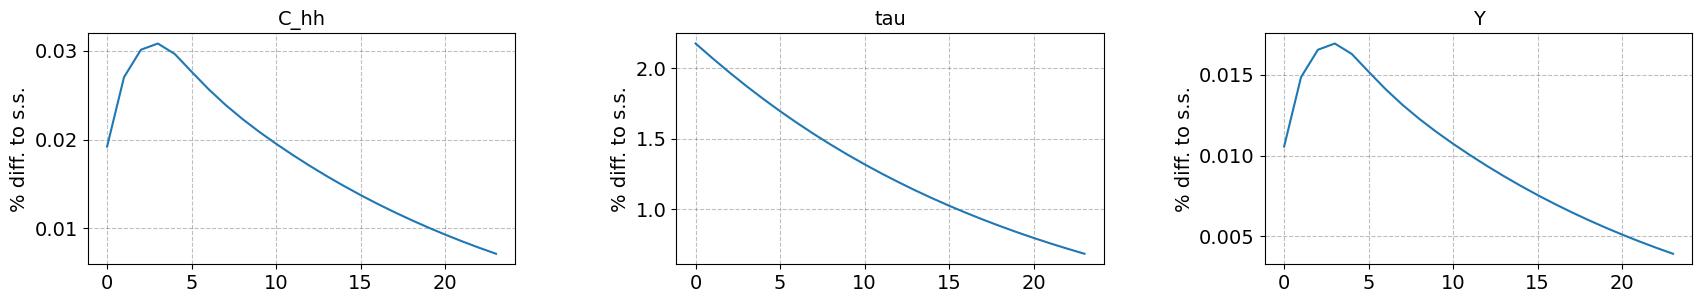

In [33]:
model4.show_IRFs(['C_hh','tau','Y'],T_max=24,do_shocks=False,do_targets=False)

In [12]:
# test remove
model_test144 = HANKSAMModelClass(name='test')
model_test144.find_ss()

ini = {}
for varname in model_test144 .varlist:
    ini[varname] = model_test144 .ss.__dict__[varname]
    ini['Dbeg'] = model_test144 .ss.Dbeg

model_test144.compute_jacs()
model_test144.find_transition_path(shocks=[], ini=ini,do_print=False)
model_test144.calc_fiscal_multiplier()

fiscal_multiplier = 0.395


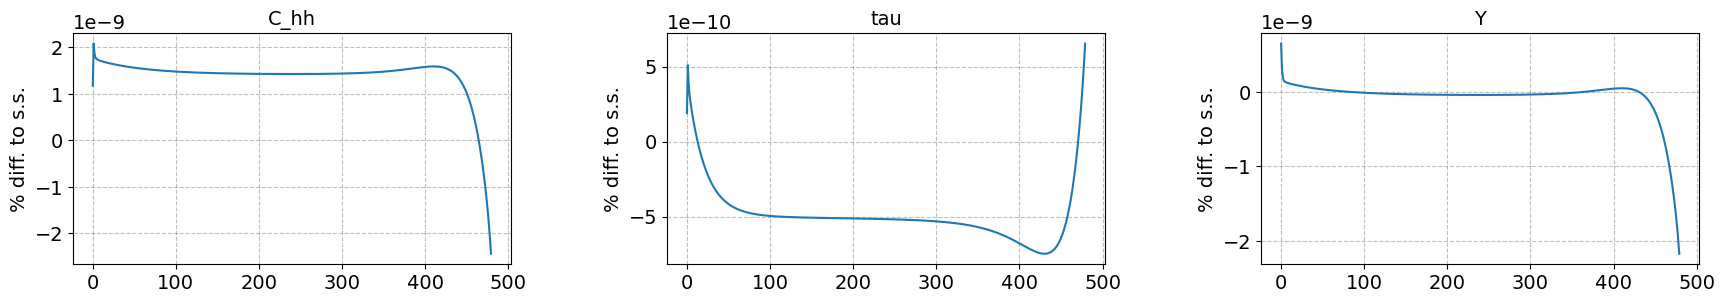

In [17]:
model_test144.show_IRFs(varnames=['C_hh', 'tau', 'Y'],do_shocks=False,do_targets=False)

### Question 3.b

In [20]:
model5 = HANKSAMModelClass()
model5.find_ss()
model5.compute_jacs()

In [21]:
ini = {}
for varname in model5.varlist:
    ini[varname] = model5.ss.__dict__[varname]
    ini['Dbeg'] = model5.ss.Dbeg

In [22]:
# find transition path
du_bar = np.zeros(par.T)
du_bar[:12] = 1 # increase in unemployment benefit duration for 12 months
shocks = {'du_bar':du_bar} 

model5.find_transition_path(do_print=True,shocks=shocks,ini=ini)

finding the transition path:
 it =   0 -> max. abs. error = 2.36e-03
   0.00e+00 in errors_Vj
   0.00e+00 in errors_Vv
   0.00e+00 in errors_u
   0.00e+00 in errors_pi
   2.36e-03 in errors_assets
   1.40e-15 in errors_U
   2.21e-03 in errors_U_UI
 it =   1 -> max. abs. error = 7.51e-04
   2.64e-13 in errors_Vj
   7.51e-04 in errors_Vv
   8.88e-06 in errors_u
   7.33e-04 in errors_pi
   2.89e-05 in errors_assets
   9.48e-06 in errors_U
   7.39e-05 in errors_U_UI
 it =   2 -> max. abs. error = 3.11e-05
   1.78e-15 in errors_Vj
   3.11e-05 in errors_Vv
   4.65e-08 in errors_u
   1.56e-05 in errors_pi
   1.67e-07 in errors_assets
   4.59e-08 in errors_U
   2.28e-07 in errors_U_UI
 it =   3 -> max. abs. error = 1.27e-06
   8.88e-16 in errors_Vj
   1.27e-06 in errors_Vv
   4.78e-09 in errors_u
   5.66e-08 in errors_pi
   6.72e-09 in errors_assets
   4.78e-09 in errors_U
   1.70e-08 in errors_U_UI
 it =   4 -> max. abs. error = 5.60e-09
   8.88e-16 in errors_Vj
   5.60e-09 in errors_Vv
   4.

### shocks ###


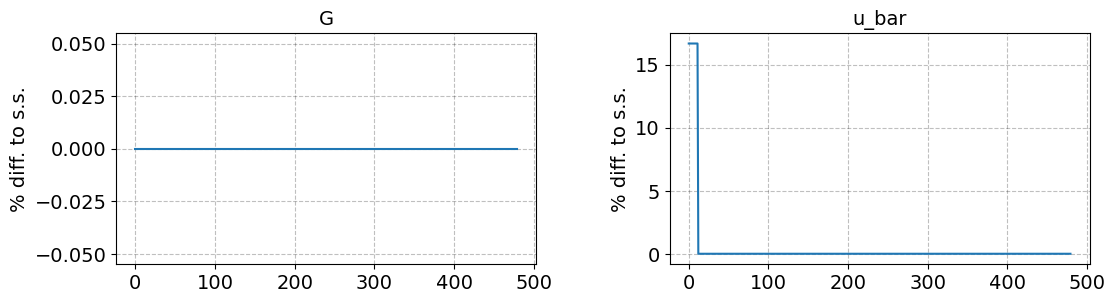


### varnames ###


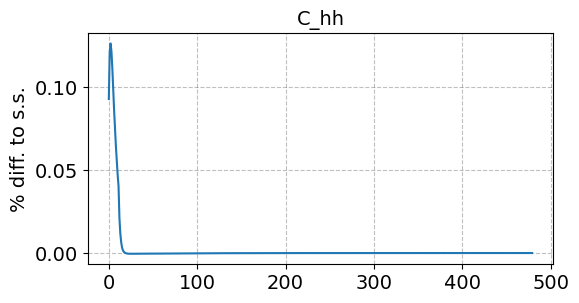


### tagets ###


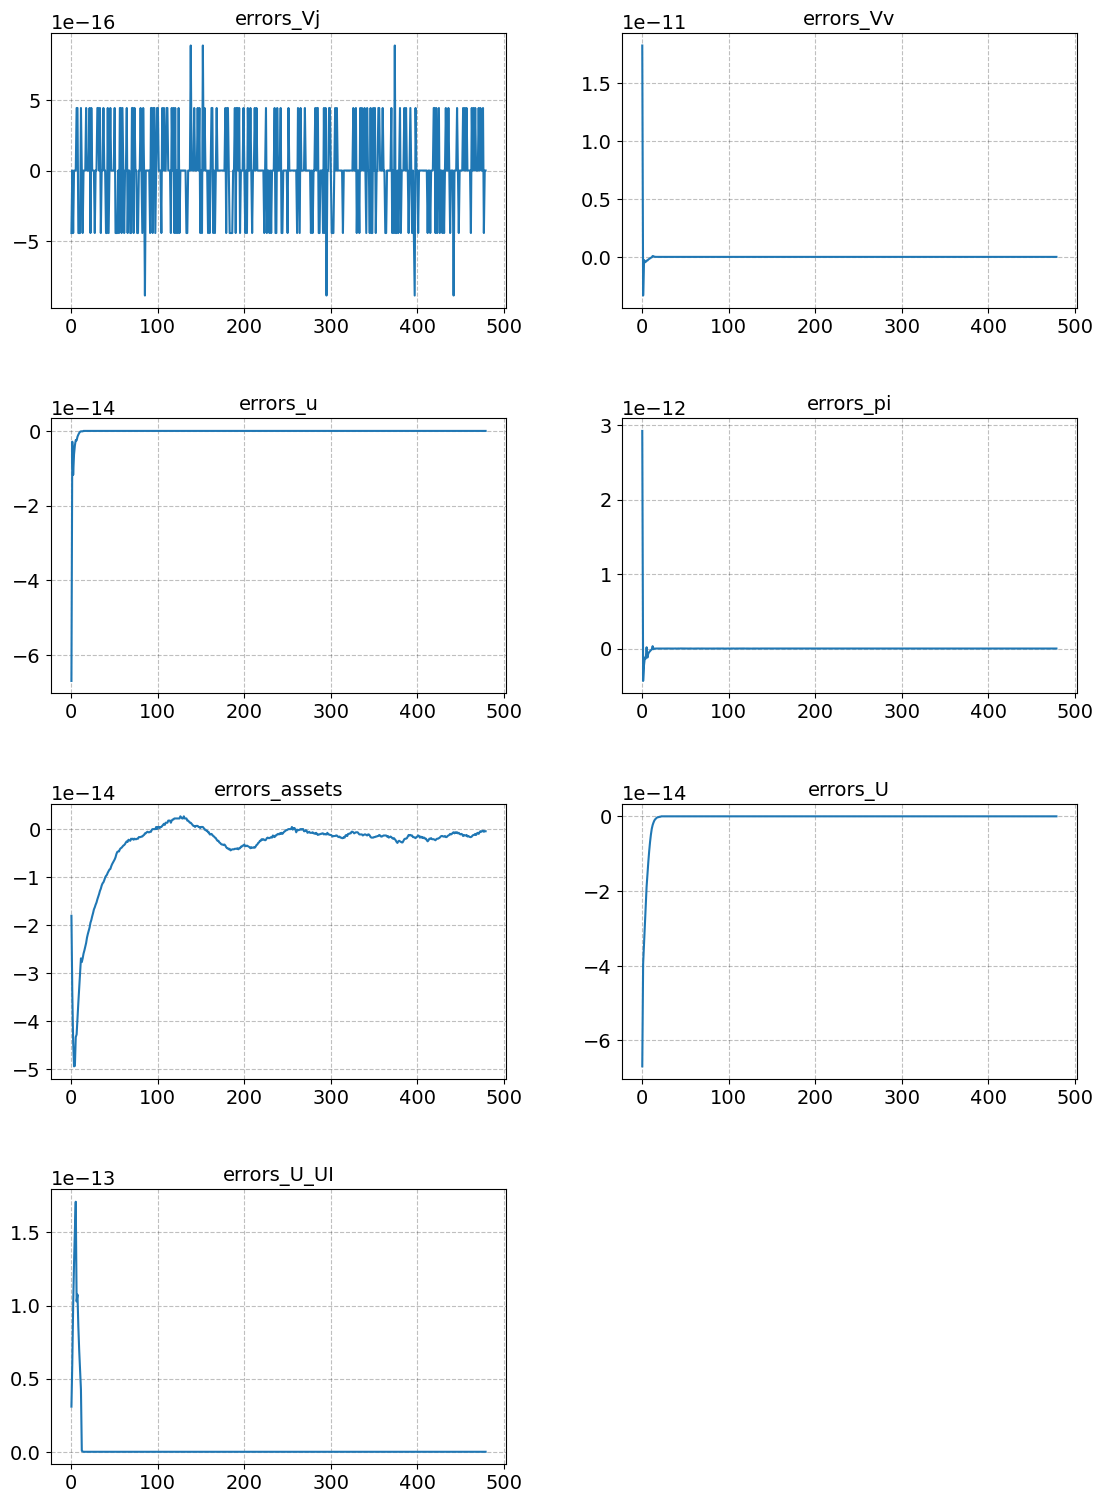

In [23]:
model5.show_IRFs(varnames=['C_hh'],ncols=2)

In [24]:
model5.calc_fiscal_multiplier()

fiscal_multiplier = 1.480


### Question 3.c

In [ ]:
model6 = HANKSAMModelClass()
model6.find_ss()
model6.compute_jacs()

In [ ]:
ini = {}
for varname in model_test1 .varlist:
    ini[varname] = model_test1 .ss.__dict__[varname]
    ini['Dbeg'] = model_test1 .ss.Dbeg

In [ ]:
# find transition path
du_bar = np.zeros(par.T)
du_bar[12:24] = 1 # increase in unemployment benefit duration for 12 months
shocks = {'du_bar':du_bar} 

model6.find_transition_path(do_print=True,shocks=shocks,ini=ini)

In [ ]:
model6.show_IRFs(varnames=['C_hh'],ncols=2)

In [ ]:
model6.calc_fiscal_multiplier()

In [ ]:
model6.compare_IRFs([model5,model6],['period 0 shock','period 12 shock'],T_max=24,varnames=['C_hh'],do_shocks=False,do_targets=False)

### Question 3.d